In [5]:
%matplotlib inline
import cv2

def imwritergb(path, img):
    cv2.imwrite(path, img[:,:,::-1])

## Accuire Vehicle and Non-vehicle paths and split to train and test

In [1]:
from sklearn.model_selection import train_test_split
import glob
import numpy as np

vehicle_sets = {
    'vehicles/GTI_MiddleClose': [
        [0,32,50,55,78,89,100,110], # Strang things happen here, manually fix
        [126,136,156,161,171,181,191],
        [200,216,226,229,239,248,267,282,290,300,310,
         313,328,332,342,349,359,366,377,387,398,400,
         403,406,409,411,414,417,420]]
}

gti_vehicle_folders = ['./vehicles/GTI_MiddleClose',
               './vehicles/GTI_Far',
               './vehicles/GTI_Left',
               './vehicles/GTI_Right']

# Fraction of samples that will be allocated as test set.
test_size_ratio = 0.2

# I choose to take the first test_size_ratio part from all paths, to avoid
# getting similar photo of same car in both testing set and training set.
# If similar photo is in both training set and testing set, then it is easy
# to get good score on testing set, even though it is because of overfitting.
# A similar photo of same car can appear in eg. both GTI_Left and GTI_MiddleClose.
# By taking first photos from all folders, I avoid probability photo of car
# from one folder ends up in testing set, while a similar photo in the other
# folder ends up in the training set, because it is roughly same order of the
# the different cars in both folders.
car_paths_train = []
car_paths_test = []
for folder in gti_vehicle_folders:
    car_paths = glob.glob(folder + '/*.png')
    assert car_paths # Assert not empty
    car_paths = list(sorted(car_paths))
    
    num_test = int(test_size_ratio * len(car_paths))
    # Allocate first test_size_ratio part as test set.
    car_paths_test.extend(car_paths[:num_test])
    # Allocate rest to train set.
    car_paths_train.extend(car_paths[num_test:])

kitti_paths = glob.glob('vehicles/KITTI_extracted/*.png')
assert kitti_paths # Assert not empty

rand_state = np.random.randint(0, 100)
kitti_vehicle_train, kitti_vehicle_test = train_test_split(
    kitti_paths, test_size=test_size_ratio, random_state=rand_state)

car_paths_train.extend(kitti_vehicle_train)
car_paths_test.extend(kitti_vehicle_test)

# The images in non-vehicles also form runs of images, but they look quite
# different inside a run, so I just randomly split it.
noncar_paths = glob.glob('./non-vehicles/**/*.png')
assert noncar_paths # Assert not empty

noncar_paths_train, noncar_paths_test = train_test_split(
    noncar_paths, test_size=test_size_ratio, random_state=rand_state)

print('car_paths_train length:', len(car_paths_train))
print('car_paths_test length:', len(car_paths_test))

print('noncar_paths_train length:', len(noncar_paths_train))
print('noncar_paths_test length:', len(noncar_paths_test))

keep_fraction = 0.1
if keep_fraction != 1:
    for paths in [car_paths_train,car_paths_test,noncar_paths_train,noncar_paths_test]:
        paths[:] = paths[:int(keep_fraction*len(paths))]

car_paths_train length: 7036
car_paths_test length: 1756
noncar_paths_train length: 7174
noncar_paths_test length: 1794


In [ ]:
#import glob
## Read in cars and notcars
#car_paths = glob.glob('./vehicles/**/*.png')
#assert car_paths # Assert not empty
#
#noncar_paths = glob.glob('./non-vehicles/**/*.png')
#assert noncar_paths # Assert not empty

In [2]:
# From course section: 'Search and Classify'
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, color_space='YCrCb'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else:
            assert False
    else: feature_image = np.copy(img)
    return feature_image

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import sklearn
import sklearn.grid_search
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

def read_images(imgpaths):
    imgs = []
    for imgpath in imgpaths:
        img = cv2.imread(imgpath)
        # Convert from BGR to RGB for to be compatible with rest of the pipline.
        img = img[:,:,::-1]
        imgs.append(img)
    return imgs

# Based on http://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator
class VehicleFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 color_space=None, spatial_size=None, hist_bins=None,
                 orient=None, pix_per_cell=None, cell_per_block=None, hog_channel=None,
                 spatial_feat=None, hist_feat=None, hog_feat=None):
        self.color_space=color_space
        self.spatial_size=spatial_size
        self.hist_bins=hist_bins
        self.orient=orient
        self.pix_per_cell=pix_per_cell
        self.cell_per_block=cell_per_block
        self.hog_channel=hog_channel
        self.spatial_feat=spatial_feat
        self.hist_feat=hist_feat
        self.hog_feat=hog_feat
    
    def fit(self, *_):
        # Let trained parameters be done in separate StandardScalar() step.
        return self
    
    # X is the RGB images
    def transform(self, X, *_):
        return [
            single_img_features(img, color_space=self.color_space, 
                        spatial_size=self.spatial_size, hist_bins=self.hist_bins,
                        orient=self.orient, pix_per_cell=self.pix_per_cell, 
                        cell_per_block=self.cell_per_block, 
                        hog_channel=self.hog_channel, spatial_feat=self.spatial_feat, 
                        hist_feat=self.hist_feat, hog_feat=self.hog_feat)
            for img in X]

cars_train = read_images(car_paths_train)
cars_test = read_images(car_paths_test)
noncars_train = read_images(noncar_paths_train)
noncars_test = read_images(noncar_paths_test)

X_train = cars_train + noncars_train
y_train = np.concatenate((np.ones(len(cars_train)), np.zeros(len(noncars_train))))

X_test = cars_test + noncars_test
y_test = np.concatenate((np.ones(len(cars_test)), np.zeros(len(noncars_test))))

steps = [('vehicle_fe', VehicleFeatureExtractor()),
        ('X_scaler', StandardScaler()),
        ('svc', LinearSVC())]
print('The scikit-learn version is {}.'.format(sklearn.__version__))
pipeline = Pipeline(steps)

parameters = dict(vehicle_fe__color_space=['HLS'], 
              vehicle_fe__orient=[9,10],
              vehicle_fe__pix_per_cell=[6,8],
              vehicle_fe__cell_per_block=[2],
              vehicle_fe__hog_channel=['ALL'],
              vehicle_fe__spatial_size=[(32,32),(28,28),(36,36)],
              vehicle_fe__hist_bins=[26,32,38],
              vehicle_fe__spatial_feat=[True],
              vehicle_fe__hist_feat=[True],
              vehicle_fe__hog_feat=[True])

grid_search = sklearn.grid_search.GridSearchCV(pipeline, param_grid=parameters)

# Check the training time for the grid search
t=time.time()
grid_search.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(grid_search.score(X_test, y_test), 4))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to do grid search...')

best_pipeline = grid_search.best_estimator_
X_scaler = best_pipeline.named_steps['X_scaler']
svc = best_pipeline.named_steps['svc']

params = grid_search.best_params_
color_space = params['vehicle_fe__color_space']
orient = params['vehicle_fe__orient']  # HOG orientations
pix_per_cell = params['vehicle_fe__pix_per_cell'] # HOG pixels per cell
cell_per_block = params['vehicle_fe__cell_per_block'] # HOG cells per block
hog_channel = params['vehicle_fe__hog_channel'] # Can be 0, 1, 2, or "ALL"
spatial_size = params['vehicle_fe__spatial_size'] # Spatial binning dimensions
hist_bins = params['vehicle_fe__hist_bins']    # Number of histogram bins
spatial_feat = params['vehicle_fe__spatial_feat'] # Spatial features on or off
hist_feat = params['vehicle_fe__hist_feat'] # Histogram features on or off
hog_feat = params['vehicle_fe__hog_feat'] # HOG features on or off


/home/mandermo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/mandermo/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


The scikit-learn version is 0.19.0.


/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_depre

/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_depre

/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_depre

/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_depre

Test Accuracy of SVC =  0.9774
1187.35 Seconds to do grid search...


In [7]:
print(params)

{'vehicle_fe__cell_per_block': 2, 'vehicle_fe__color_space': 'HLS', 'vehicle_fe__hist_bins': 32, 'vehicle_fe__hist_feat': True, 'vehicle_fe__hog_channel': 'ALL', 'vehicle_fe__hog_feat': True, 'vehicle_fe__orient': 10, 'vehicle_fe__pix_per_cell': 8, 'vehicle_fe__spatial_feat': True, 'vehicle_fe__spatial_size': (32, 32)}


7


/home/mandermo/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


test_prediction:  [ 1.79875243]
test_prediction:  [ 1.51795372]
test_prediction:  [ 1.74299204]
test_prediction:  [ 1.87572589]
test_prediction:  [ 1.57734025]
test_prediction:  [ 1.59358871]
test_prediction:  [ 1.97190197]
test_prediction:  [ 1.87038364]
test_prediction:  [ 1.97363329]
test_prediction:  [ 2.48278023]
test_prediction:  [ 2.53063112]
test_prediction:  [ 1.72000764]
test_prediction:  [ 2.49925374]
test_prediction:  [ 1.75073545]
test_prediction:  [ 2.66871553]
test_prediction:  [ 2.80948371]
test_prediction:  [ 2.42658332]
test_prediction:  [ 2.55285371]
test_prediction:  [ 2.43932794]
test_prediction:  [ 2.11915083]
test_prediction:  [ 1.72820147]
test_prediction:  [ 2.26595993]
test_prediction:  [ 1.87729801]


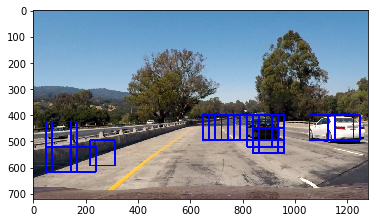

In [6]:
# Based on code from section "Hog Sub-sampling Window Search"
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    print(nblocks_per_window)
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            #test_prediction = svc.predict_proba(test_features)
            #print('test_prediction: ', test_prediction)
            test_prediction = svc.decision_function(test_features)
            if test_prediction > 1.5:
                print('test_prediction: ', test_prediction)
            #if test_prediction[0][1] > .999:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

ystart = 400
ystop = 656
scale = 1.5

img = cv2.imread('test_images/test1.jpg')
img = img[:,:,::-1] # bgr to rgb

out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
imwritergb('output_images/hogsearch.jpg', out_img)